In [1]:
"""
Create a uniformly spaced (lon,lat) grid of initial particle locations based on nemo bathymetry
"""

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap

griddir = '/scratch/judithe/'

spacing=5 #spacing between particles
name='5'

plotspacing=2 #For binning of final plot
outdir=griddir + 'Natl' + name + 'grid/'

def create_particles():
    #Create uniform grid of particles
    filename=griddir + 'bathy_level.nc'
    data = Dataset(filename,'r')
    bathy=np.array(data['Bathy_level'][0])
    lon=np.array([data['nav_lon']][0])
    lat=np.array([data['nav_lat']][0])
        
    grid=np.mgrid[-100:30:spacing,0:75:spacing]
    n=grid[0].size;
    lons=np.reshape(grid[0],n)
    lats=np.reshape(grid[1],n)
    
    #Remove pacific part
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< - lo - 75)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< - lo - 75)])]
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 10 and lo<-70)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 10 and lo<-70)])]    
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 15 and lo<-83)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 15 and lo<-83)])]    
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 12 and lo<-82) ]),np.array([la for lo, la in zip(lons,lats) if not (la< 12 and lo<-82)])] 
       
    #Remove mediterranian
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 48 and la > 30 and lo >0)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 48 and la > 30 and lo >0)])]    
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 39 and la > 35 and lo >-7)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 39 and la > 35 and lo >-7)])]        
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (lo<5. and lo>-5 and la<41 and la>35)  ]),np.array([la for lo, la in zip(lons,lats) if not (lo<5. and lo>-5 and la<41 and la>35)])] 
    
    #remove some parts in canada
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la> 50 and la<72 and lo < -70)  ]),np.array([la for lo, la in zip(lons,lats) if not (la> 50  and la<72 and lo < -70)])]            
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (lo < -78 and la > 71)  ]),np.array([la for lo, la in zip(lons,lats) if not (lo < -78 and la > 71)])]            

#    #Remove Ostsee
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la<65 and lo > 10)  ]),np.array([la for lo, la in zip(lons,lats) if not (la<65 and lo > 10)])]            
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la>60 and la<67 and lo > 20)  ]),np.array([la for lo, la in zip(lons,lats) if not (la>60 and la<67 and lo > 20)])]            
#    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if Land[0,lo,la,0]==0.0 and not (lo>354. and la<40. and la>30.) and not (lo<288. and la>50.)  and not (lo<295.5 and lo>290. and la>57.) and not (lo<283. and la<8.6) and not (lo>357. and la> 52.)]),np.array([la for lo, la in zip(lons,lats) if Land[0,lo,la,0]==0.0 and not (lo>354. and la<40. and la>30.) and not (lo<288. and la>50.) and not (lo<295.5 and lo>290. and la>57.) and not (lo<283. and la<8.6) and not (lo>357. and la>52.)])] 
    
    bathy_points = griddata(np.array([lon.flatten(), lat.flatten()]).T, bathy.flatten(), (lons, lats), method='nearest')
    
    lons_new=np.array([lons[i] for i in range(len(lons)) if bathy_points[i]!=0])
    lats_new=np.array([lats[i] for i in range(len(lats)) if bathy_points[i]!=0])
    
    #lons_new[lons_new<0]+=360
        
    np.save(outdir+'Lons_full' + str(name),lons_new)
    np.save(outdir+'Lats_full' + str(name),lats_new)

create_particles()

Number of particles: 198


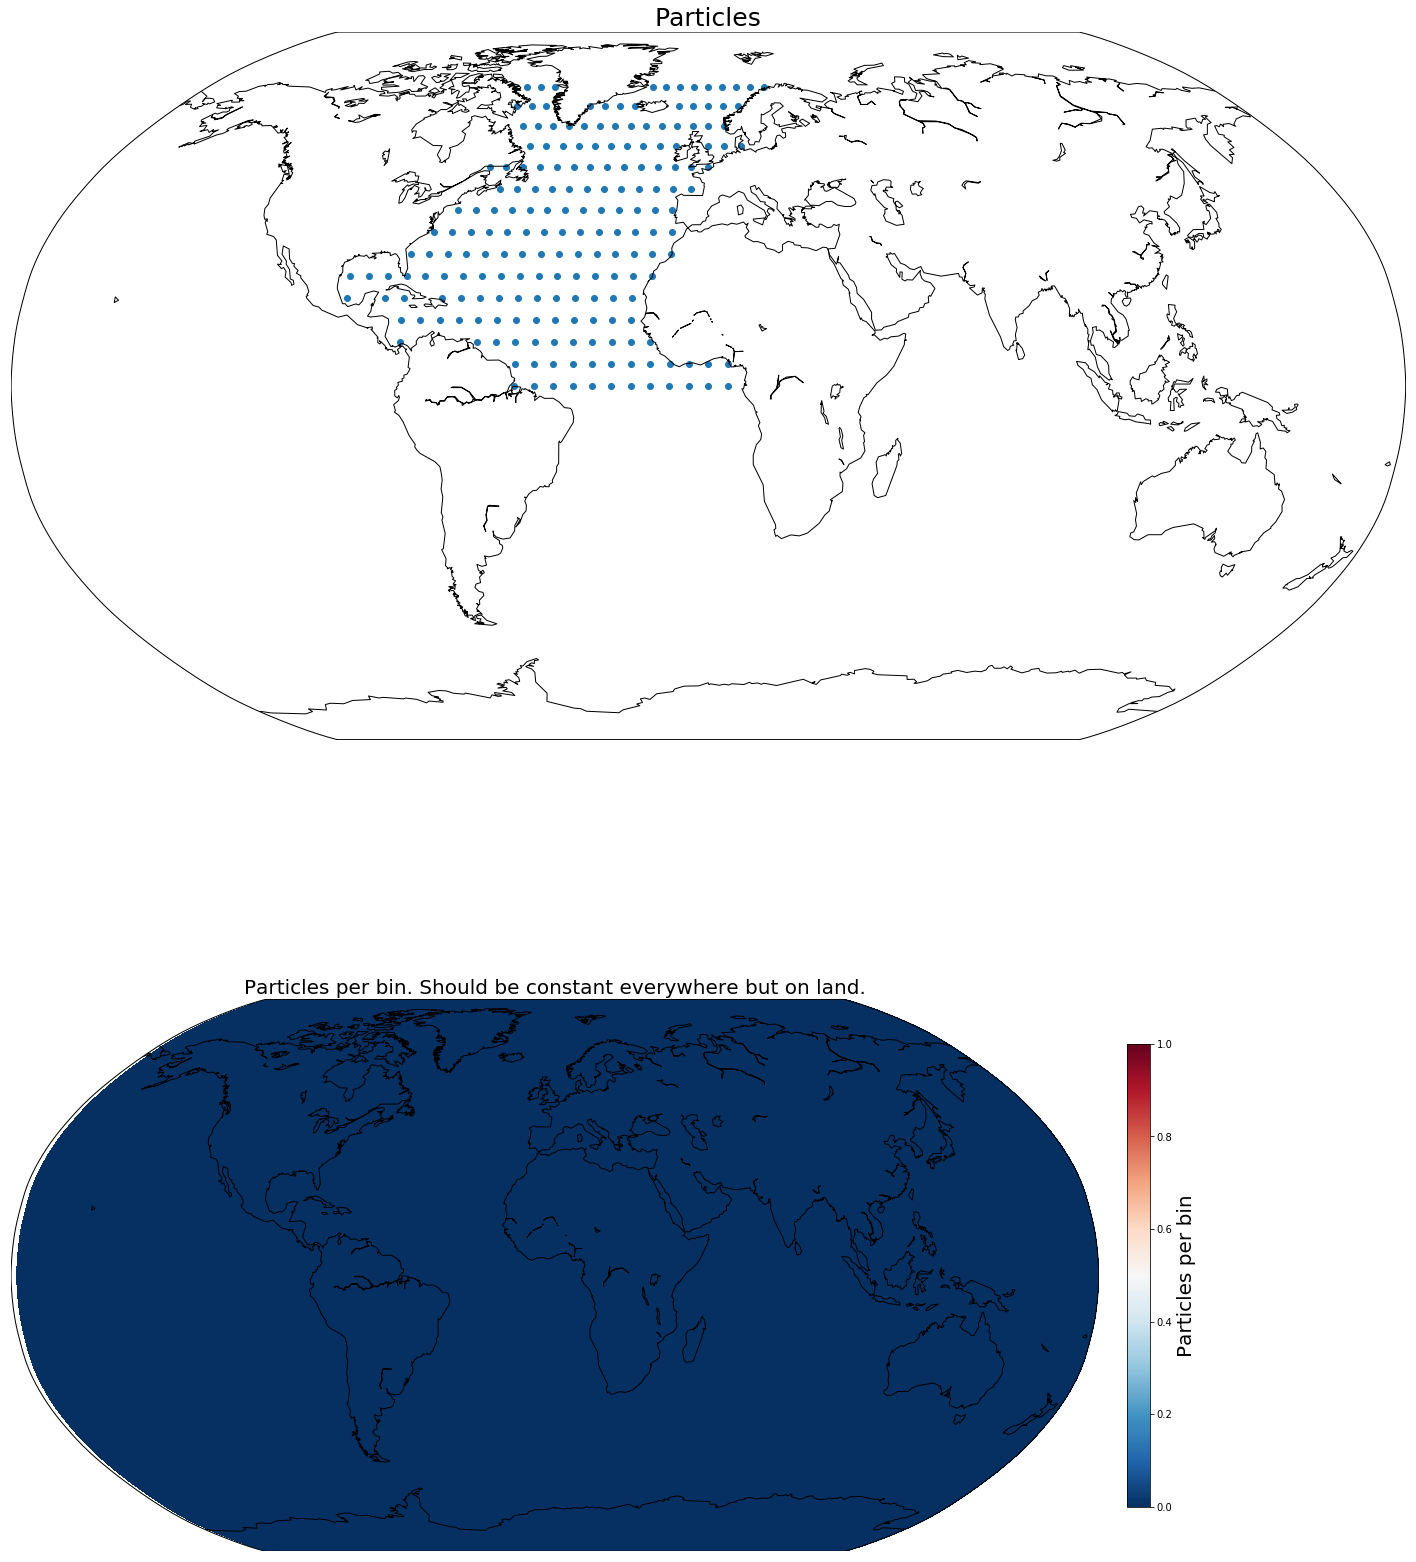

In [2]:
def Plot_particles():
    #Plot to check if everything went well
    lons=np.load(outdir + 'Lons_full' + str(name) + '.npy')
    lats=np.load(outdir + 'Lats_full' + str(name) + '.npy')
    
    assert (len(lons)==len(lats))
    
    print ('Number of particles: %s' % len(lons))
    fig = plt.figure(figsize=(25, 30))
    ax = fig.add_subplot(211)
    ax.set_title("Particles", fontsize=25)
    
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawcoastlines()
    xs, ys = m(lons, lats)
    m.scatter(xs,ys)
    
    ax = fig.add_subplot(212)
    ax.set_title("Particles per bin. Should be constant everywhere but on land.", fontsize=20)

    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawcoastlines()

    lon_bin_edges = np.arange(0, 360+spacing, plotspacing)
    lat_bins_edges = np.arange(-90, 90+spacing, plotspacing)
    
    density, _, _ = np.histogram2d(lats, lons, [lat_bins_edges, lon_bin_edges])
    
    lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bin_edges, lat_bins_edges)
    xs, ys = m(lon_bins_2d, lat_bins_2d)

    plt.pcolormesh(xs, ys, density,cmap=plt.cm.RdBu_r)
    cbar = plt.colorbar(orientation='vertical', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
    cbar.set_label('Particles per bin',size=20)
    plt.savefig('Particles5.png')

Plot_particles()

In [3]:
def split_grid():
    
    for name in ['5']:
        Lons = np.load(griddir + 'Natl' + name + 'grid//Lons_full' + name + '.npy')
        Lats = np.load(griddir + 'Natl' + name + 'grid//Lats_full' + name + '.npy')
       
        print ('Total number of particles: %s' % len(Lons))
        
        outdir='/scratch/judithe/Natl' + name + 'grid/'
        N=40 #Number of sub-grids
        
        k = len(Lons)//N+1 #Number of particles per file
        print (k)
        
        for i in range(0,len(Lons)//k+1):
            lo = Lons[i*k:(i+1)*k]
            la = Lats[i*k:(i+1)*k]
            np.save(outdir + 'Lons' + str(i), lo)
            np.save(outdir + 'Lats' + str(i), la)
            print ('lo shape: %s' % lo.shape)
            print ('la shape: %s' % la.shape)

split_grid()

Total number of particles: 198
5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 5
la shape: 5
lo shape: 3
la shape: 3


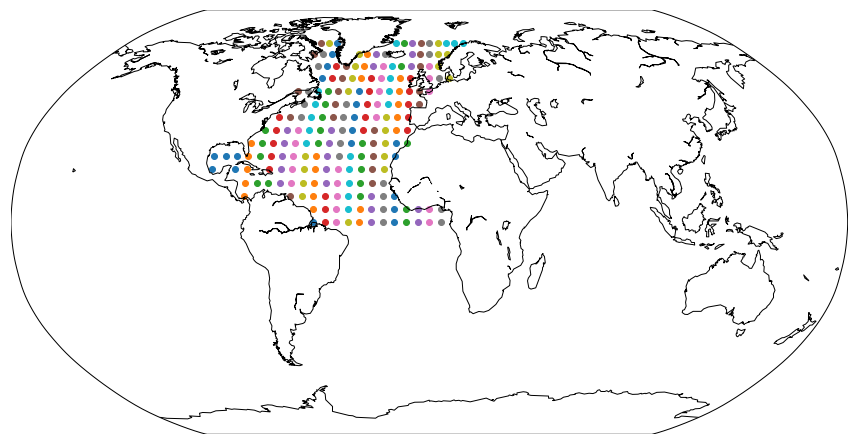

In [4]:
def plot_grid():
    ##For testing the distribution
    from mpl_toolkits.basemap import Basemap
    
    plt.figure(figsize=(15,15))
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    #m = Basemap(projection='mill', llcrnrlat=-89., urcrnrlat=89., llcrnrlon=0., urcrnrlon=360., resolution='l')
    m.drawcoastlines()
        
    for i in range(40):
        Lons = np.load('/scratch/judithe/Natl5grid/Lons' + str(i) + '.npy')
        Lats = np.load('/scratch/judithe/Natl5grid/Lats' + str(i) + '.npy')
        
        xs, ys = m(Lons, Lats)
        m.scatter(xs,ys)
    
plot_grid()